# AI Customer Support assistant for an Airline

## The goal is to create an AI assistant to help customers plan their airline travel.

In [1]:
# imports

import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr

# Some imports for handling images

import base64
from io import BytesIO
from PIL import Image
# Audio

from IPython.display import Audio, display

# For ticket
#! pip install reportlab
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas
import smtplib
from email.message import EmailMessage

In [2]:
# Initialization
# We will use "gpt-4o-mini'
load_dotenv(override=True)

openai_api_key = os.getenv('OPENAI_API_KEY')
email_sender = os.getenv('Email_sender')
password_sender = os.getenv('Password_sender')
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")

if email_sender:
    print("Company email exists")
else:
    print("Company email not set")

if password_sender:
    print("Company email password set")
else:
    print("Password not set")

    
MODEL = "gpt-4o-mini"
openai = OpenAI()

OpenAI API Key exists and begins sk-proj-
Company email exists
Company email password set


In [3]:
system_message = "You are a helpful assistant for an Airline called FlightAI. "
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."

In [4]:
# Let's start by making a useful function
# The price that is used is only for an example.

ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499", "benin": "$1250", "rome": "$950"}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")

In [5]:
get_ticket_price("London")

Tool get_ticket_price called for London


'$799'

In [6]:
get_ticket_price("Italy")

Tool get_ticket_price called for Italy


'Unknown'

In [7]:
def collect_passenger_info(tool_response):
    passenger_data = {
        "Full Name": tool_response['full_name'],
        "Date of Birth": tool_response['date_of_birth'],
        "Nationality": tool_response['nationality'],
        "Passport Number": tool_response['passport_number'],
        "Email": tool_response['email'],
        "Phone": tool_response['phone']
    }

    # You can add here additional checks or processes
    print("Passenger information collected successfully:")
    #for key, value in passenger_data.items():
     #   print(f"{key}: {value}")

    return passenger_data


## Define the tools

In [8]:
# There's a particular dictionary structure that's required to describe our 'get_ticket_price' function:

price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

In [9]:
# There's a particular dictionary structure that's required to describe our 'collect_passenger_info' function:

passenger_info_function ={
        "name": "collect_passenger_info",
        "description": "Collect personal information required for booking a flight ticket.",
        "parameters": {
            "type": "object",
            "properties": {
                "full_name": {
                    "type": "string",
                    "description": "Full name exactly as it appears on the passport or national ID."
                },
                "date_of_birth": {
                    "type": "string",
                    "format": "date",
                    "description": "Date of birth in YYYY-MM-DD format."
                },
                "nationality": {
                    "type": "string",
                    "description": "Passenger's nationality."
                },
                "passport_number": {
                    "type": "string",
                    "description": "Passport number (required for international flights)."
                },
                "email": {
                    "type": "string",
                    "format": "email",
                    "description": "Contact email address."
                },
                "phone": {
                    "type": "string",
                    "description": "Contact phone number including country code."
                }
            },
            "required": [
                "full_name",
                "date_of_birth",
                "nationality",
                "passport_number",
                "email",
                "phone"
            ],
            "additionalProperties": False
        }
    }

In [10]:
# And this is included in a list of tools:

tools = [{"type": "function", "function": price_function}, {"type": "function", "function": passenger_info_function}]

## Make image

In [11]:
def artist(city):
    image_response = openai.images.generate(
            model="dall-e-3",
            prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

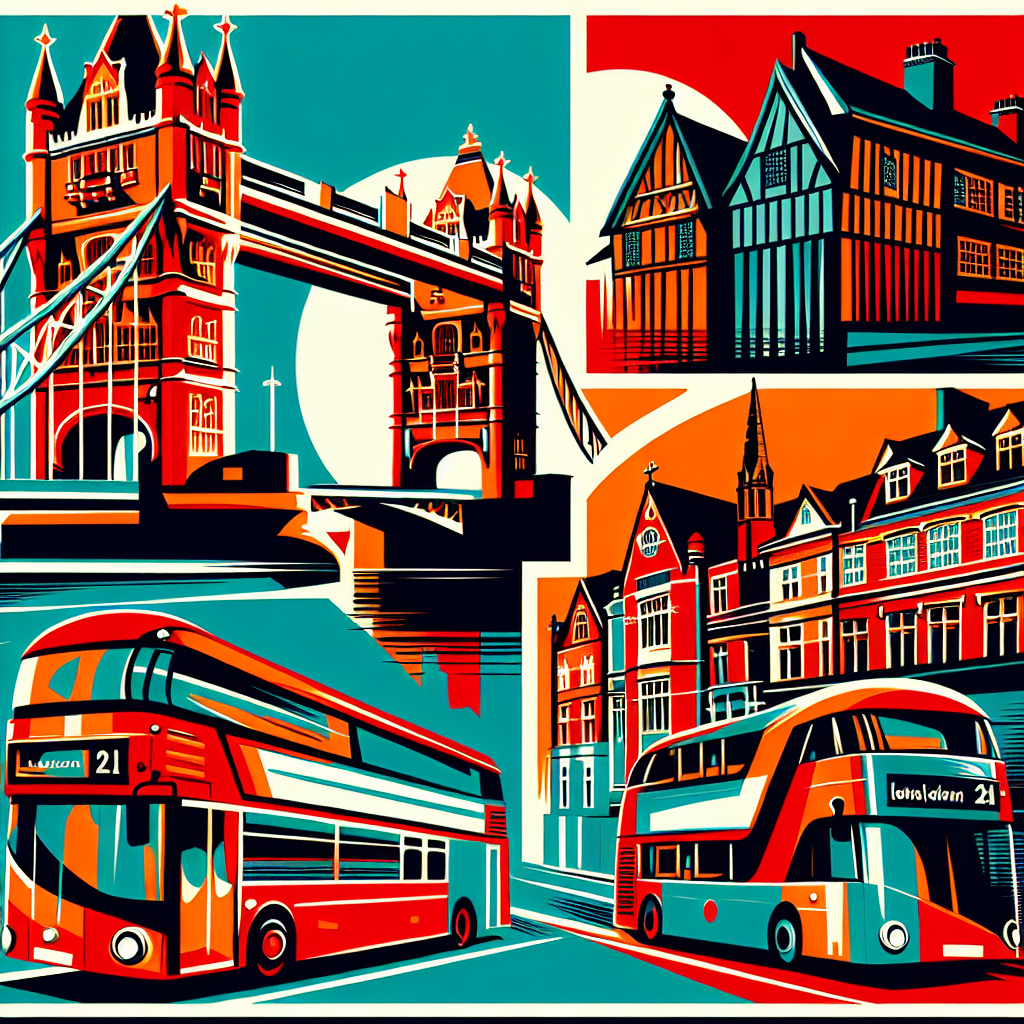

In [14]:
image = artist("London city")
display(image)

## Audio 

In [27]:
def talker(message):
    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx",   # # Also, try replacing onyx with alloy. We could also use echo, fable, nova, shimmer
        input=message)

    audio_stream = BytesIO(response.content)
    output_filename = "output_audio.mp3"
    with open(output_filename, "wb") as f:
        f.write(audio_stream.read())

    # Play the generated audio
    display(Audio(output_filename, autoplay=True))

In [28]:
talker("Hello!, how are you doing?")

## Ticket generator

In [13]:
def generate_pdf(info, filename="confirmation_vol.pdf"):
    c = canvas.Canvas(filename, pagesize=A4)
    width, height = A4

    c.setFont("Helvetica-Bold", 16)
    c.drawString(50, height - 50, "Flight reservation confirmation")

    c.setFont("Helvetica", 12)
    y = height - 100
    for key, value in info.items():
        label = key.replace("_", " ").capitalize()
        c.drawString(50, y, f"{label} : {value}")
        y -= 20

    c.drawString(50, y - 20, "Status: Reservation confirmed âœ…")
    c.save()

    return filename

In [14]:
def sender_email_with_pdf(info):
    smtp_config = {
    "host": "smtp.gmail.com",
    "port": 465,
    "email": email_sender,
    "password": password_sender}
    
    # PDF generation
    pdf_file = generate_pdf(info)

    # Message to send
    msg = EmailMessage()
    msg["Subject"] = "Confirmation of your flight"
    msg["From"] = smtp_config["email"]
    msg["To"] = info['email']
    msg.set_content(f"""
Hello {info['full_name']},

Please find attached your flight reservation confirmation.

Thank you for your trust.

Best regards,
Reservations Department
""")

    # Adding the PDF file
    with open(pdf_file, "rb") as f:
        msg.add_attachment(f.read(), maintype="application", subtype="pdf", filename=pdf_file)

    # Sending the message
    with smtplib.SMTP_SSL(smtp_config["host"], smtp_config["port"]) as smtp:
        smtp.login(smtp_config["email"], smtp_config["password"])
        smtp.send_message(msg)

    # Cleaning
    os.remove(pdf_file)

    print("Email successfully sent to", info['email'])


## Agent Framework

The Agent Framework here aims to break a complex problem into smaller steps, with multiple LLMs carrying out specialized tasks and to use tools for additional capabilities.

In [29]:
def chat(history):
    messages = [{"role": "system", "content": system_message}] + history
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools, tool_choice="auto")
    image = None
    
    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        chek = message.tool_calls[0].function.arguments
        print(chek)
        if "destination_city" in chek:
            response, city = handle_tool_call(message)
            image = artist(city)
        else:
            response = passenger_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
        
    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content":reply}]

    # Comment out or delete the next line if you'd rather skip Audio for now..
    talker(reply)
    
    return history, image

In [30]:
# We have to write that function handle_tool_call:

def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    price = get_ticket_price(city)
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city,"price": price}),
        "tool_call_id": tool_call.id
    }
    return response, city

In [31]:
# We have to write  the function passenger_tool_call:

def passenger_tool_call(message):
    tool_response = {}
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    tool_response['full_name'] = arguments.get('full_name')
    tool_response['date_of_birth'] = arguments.get('date_of_birth')
    tool_response['nationality'] = arguments.get('nationality')
    tool_response['passport_number'] = arguments.get('passport_number')
    tool_response['email'] = arguments.get('email')
    tool_response['phone'] = arguments.get('phone')
    passenger_info = collect_passenger_info(tool_response)
    sender_email_with_pdf(tool_response)
    response = {
        "role": "tool",
        "content": json.dumps(passenger_info),
        "tool_call_id": tool_call.id
    }
    return response


In [32]:
# Define this variable and then pass js=force_dark_mode when creating the Interface
# JavaScript Script 

force_dark_mode = """
function refresh() {
    const url = new URL(window.location);
    if (url.searchParams.get('__theme') !== 'dark') {
        url.searchParams.set('__theme', 'dark');
        window.location.href = url.href;
    }
}
"""

In [33]:
# Chat interface using Gradio 
# Passing in inbrowser=True in the last line will cause a Gradio window to pop up immediately.
# If you don't need dark theme, we can remove "js=force_dark_mode"

with gr.Blocks(js=force_dark_mode) as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, history):
        history += [{"role":"user", "content":message}]
        return "", history

    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )
    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

In [34]:
ui.launch() # inbrowser=True

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


{"destination_city":"London"}
Tool get_ticket_price called for London


{"full_name":"Hippolyte SODJINOU","date_of_birth":"2003-06-25","nationality":"Benin","passport_number":"P24555555","email":"hippolytesuccess@gmail.com","phone":"01365487925"}
Passenger information collected successfully:
Email successfully sent to hippolytesuccess@gmail.com
